In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
import pandas as pd
import numpy as np

# allows importing notebooks as modules
from notebook_import import *

D:\Programs\Anaconda\envs\py35\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from log_parsing_notebook import load_behavioral_data, compile_trials
from utility_functions import prop_true

TDMS_PATH = 'D:/Work/tdms_logs'
TXT_PATH = 'D:/Dropbox/Work/envelope_discrimination/txt_logs'
CSV_PATH = 'D:/Dropbox/Work/envelope_discrimination/csv_logs'
RATS = ['S8','S9','S10']

importing Jupyter notebook from D:\Dropbox\Work\iPython\log_parsing_notebook.ipynb
importing Jupyter notebook from D:\Dropbox\Work\iPython\utility_functions.ipynb


In [3]:
# load behavioral data into memory
ld = load_behavioral_data(TXT_PATH,TDMS_PATH,CSV_PATH,RATS)

In [4]:
drop_sessions = ['20160712S8', # task parameter (delay) changed and the rat was confused
                 '20160713S8',
                 '20160714S8',
                 '20160715S8',
                 '20160716S8',
                 '20160717S8']



sessions_with_mixed_trials = pd.Series([s for s in ld.index if 'Mixed_trial_info' in ld[s].keys() 
                              # only select sessions with '5-1' sequences present (these will also contain '1-5') 
                              and '5-1' in ld[s].Mixed_trial_info.unique()
                              # drop some sessions for various reasons
                              and s not in drop_sessions])

# leave only relevant sessions with mixed trials
ld = ld[sessions_with_mixed_trials]
print('There are %s sessions with mixed trials.' % len(ld))

There are 114 sessions with mixed trials.


D:\Programs\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [5]:
# create a tidy dataset with all trials
trials = compile_trials(ld)

print('There are %s trials in total, %s of them are mixed trials' %
     (len(trials), len(trials.dropna(subset=['mixed_sequence']))) )

There are 27659 trials in total, 1594 of them are mixed trials


#### Visualize performance on normal trials for each rat and session
This allows to see trends in the long-term, and visually check if performance in some periods is strangely low. Chance performance is 50%.

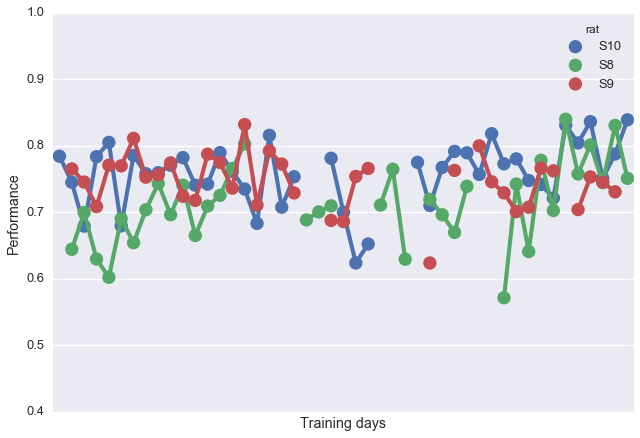

In [6]:
# get normal trials only
nt = trials[trials.mixed_sequence.isnull()]

# groupby rat and date and calculate proportion of correct trials,
# which gives performance on each session for each rat
perf = nt.groupby(['rat','date']).correct.apply(prop_true).reset_index()

# plot
sns.pointplot(data=perf,x='date',y='correct',hue='rat')
plt.xticks([])
plt.xlabel('Training days')
plt.ylim([0.4,1])
plt.ylabel('Performance')
plt.show()

#### Analyse mixed trials
Mixed trials are trials with one modulation frequency in the first second and another in the second second: 1 Hz in the first second and 5 Hz in the second second (1-5 mixed sequence), or vice versa (5-1 mixed sequence). The question is how rats decide to choose on these trials -- according to the first modulation frequency or the second one. This will tell us which part of the stimulus has more weight for the animal.

In [37]:
# get only mixed trials
mt = trials[trials.mixed_sequence.notnull()]

# calculate proportion of choice to right for 5-1 and 5-1 mixed sequences for each rat 
prop_right = mt.groupby(['rat','mixed_sequence'])['choice'].apply(lambda x: sum(x=='Right')/len(x)).reset_index()
prop_right.rename(columns={"choice": "prop_choices_right"},inplace=True)
prop_right

,rat,mixed_sequence,prop_choices_right
0,S10,1-5,0.718412
1,S10,5-1,0.259786
2,S8,1-5,0.709924
3,S8,5-1,0.426415
4,S9,1-5,0.738462
5,S9,5-1,0.373494


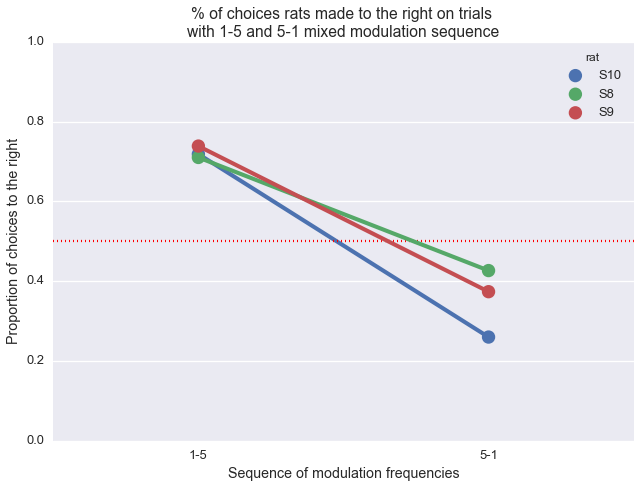

In [39]:
sns.pointplot(data=prop_right,x='mixed_sequence',y='prop_choices_right',hue='rat')

# chance level choice
plt.hlines(0.5,*plt.gca().get_xlim(),linestyles=':',colors='r')

plt.ylim([0,1])
plt.ylabel('Proportion of choices to the right')
plt.xlabel('Sequence of modulation frequencies')
plt.title('% of choices rats made to the right on trials \nwith 1-5 and 5-1 mixed modulation sequence')
plt.show()

On normal trials rats were trained to make right choice on 5 Hz modulation, and left choice on 1 Hz modulation, and their performance is high on these trials. Mixed trials were rewarded on either side, and had no obvious side of choice, since both 1 Hz and 5 Hz modulation were present on each trial, only the order was different. Despite this, all 3 experimental rats clearly tended to choose right on 1-5 trials and left on 5-1 trials, which means that they tended to choose according to the **second** modulation frequency presented on mixed trial.

Next question we ask is how performance on the mixed trials (i.e. % of choices made in accordance with the second frequency in the mixed sequence) compares with the performance on normal trials. Is it statistically different from normal performance or not? This will tell us whether the rats take first frequency into account on mixed trials or just ignore it.

In [40]:
trials

,trial_num,correct,reward,choice,gain,mixed_sequence,date,rat
0,0,True,both,Right,1.0,5-1,2016-06-08,S8
1,1,True,Left,Left,1.0,NaN,2016-06-08,S8
2,7,False,Left,Right,0.8,NaN,2016-06-08,S8
3,10,False,Right,Left,1.2,NaN,2016-06-08,S8
4,12,True,Left,Left,1.2,NaN,2016-06-08,S8
5,14,False,Right,Left,1.2,NaN,2016-06-08,S8
6,16,True,Left,Left,0.8,NaN,2016-06-08,S8
7,18,False,Left,Right,1.0,NaN,2016-06-08,S8
8,20,True,Left,Left,0.8,NaN,2016-06-08,S8
9,22,True,Right,Right,1.0,NaN,2016-06-08,S8
